In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report

nltk.download('punkt')
nltk.download('stopwords')

2024-03-25 20:22:51.643179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 20:22:51.643283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 20:22:51.777838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [3]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [4]:
#test

In [5]:
#X_test = test['text']

In [6]:
#df.sample(20)

In [7]:
print(df['keyword'].value_counts())
print(df['keyword'].nunique())

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64
221


In [8]:
print(df['target'].value_counts())

target
0    4342
1    3271
Name: count, dtype: int64


Text(0, 0.5, 'Count')

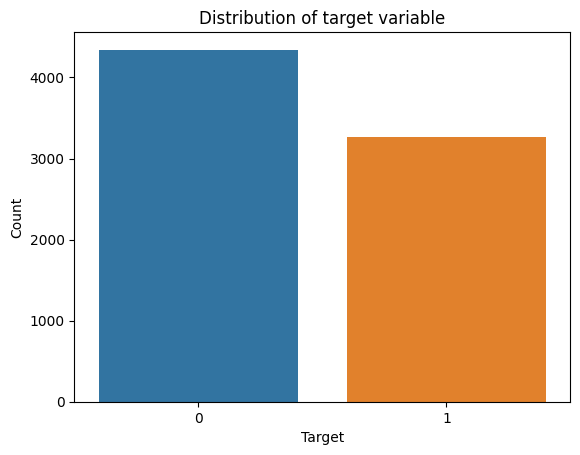

In [9]:
sns.countplot(data=df, x='target')
plt.title('Distribution of target variable')
plt.xlabel('Target')
plt.ylabel('Count')

In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Find the longest tweet in whole dataset

In [12]:
all_data = pd.concat([df, test])

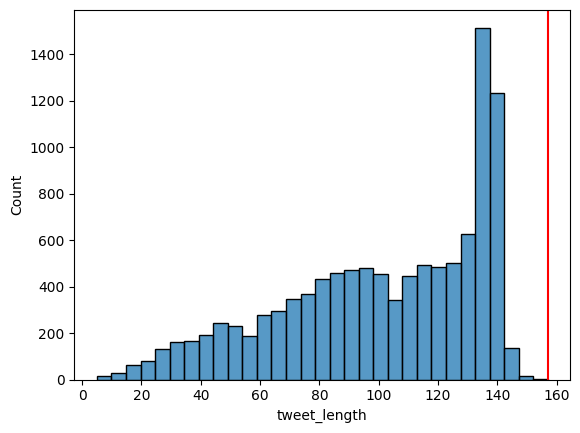

In [13]:
all_data['tweet_length'] = all_data.text.apply(len)
sns.histplot(all_data['tweet_length'])
plt.axvline(all_data['tweet_length'].max(), c='red')
plt.show()

### Compare length distribution of disaster and non disaster tweets 

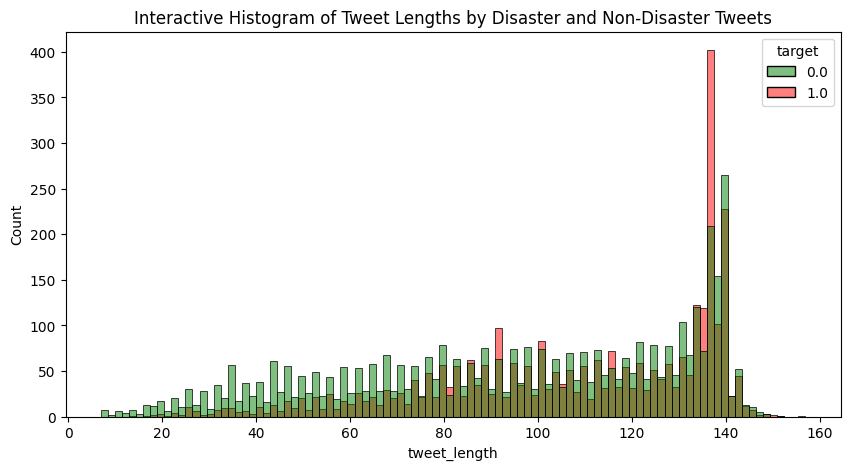

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(
    data=all_data,
    x='tweet_length',
    hue='target',
    bins=100,
    palette={0: 'green', 1: 'red'}
)

plt.title("Interactive Histogram of Tweet Lengths by Disaster and Non-Disaster Tweets")
plt.show()

# TEXT PREPROCESSING

1. CHAT WORDS

In [15]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [16]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.upper() in chat_words:
            words[i] = chat_words[word.upper()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)
test['text'] = test['text'].apply(replace_chat_words)

2.NON ALPHA NUMERIC CHARACTERS

In [17]:
#df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

#df.sample(10)

3. STOP WORDS

In [18]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test["text"] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason #earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked 'shelter place' notified o...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent photo Ruby #Alaska smoke #wildfi...,1


4. LOWERCASING

In [19]:
df['text'] = df['text'].str.lower()
test['text'] = test['text'].str.lower()

5. REMOVING NUMERIC

In [20]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
test['text'] = test['text'].str.replace(r'\d+', '', regex=True)

6.  REMOVING WHITE SPACE

In [21]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
test['text'] = test['text'].str.replace(r'\s+', ' ', regex=True)

7. REMOVING SPECIAL CHARACTER

In [22]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
test['text'] = test['text'].str.replace(r'[^\w\s]', '', regex=True)

8. REMOVING URLS

In [23]:
df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
test['text'] = test['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)

9. APPLIED STEMMING

In [24]:
# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Function to apply stemming to a text
def apply_stemming(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply stemming to the 'text' column
df['text'] = df['text'].apply(apply_stemming)
test['text'] = test['text'].apply(apply_stemming)

In [25]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [26]:
X_train = df['text']

In [27]:
X_test = test['text']

In [28]:
# X_train['keyword'].fillna('Missing')

In [29]:
X_train.sample(10)

1008    drake bodi bag meek meanwhil he tour nicki hus...
352     see armi whitewalk first thing slightli intrig...
4799    kijima_matako break news unconfirm i heard lou...
316     your phone is spi on you hidden back door nsa ...
408     arson suspect link fire caught northern califo...
4569    my babi girl car wreak afternoon thank god ser...
387     mourn notic stab arson victim stir ûpolit grie...
6550                                well dad surviv drive
948                                   turn espn get blown
3799                  monster truck racer catch fire fair
Name: text, dtype: object

In [30]:
# X_train['keyword'].value_counts()

In [31]:
y_train = df['target']

In [32]:
y_train.nunique()

2

In [33]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [34]:
OOV_TYPE = '<OOV'


tokenizer = Tokenizer(num_words=200000, oov_token=OOV_TYPE)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
print(list(word_index.keys())[:20])

['<OOV', 'i', 'the', 'like', 'a', 'fire', 'get', 'im', 'amp', 'you', 'new', 'via', 'bomb', 'it', 'in', 'one', 'go', 'peopl', 'news', 'kill']


In [35]:
X_train_sequences = tokenizer.texts_to_sequences(x_train)
X_val_sequences = tokenizer.texts_to_sequences(x_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [36]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences+X_val_sequences+X_test_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 28


In [37]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [38]:
X_train_padded[0]

array([3335,  151,  266,  590, 3336, 2172, 3337,  798,  651, 3338, 4879,
       3339, 3340,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [39]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

16121

### Convert labels to tensors

In [40]:
y_train_tensor = tf.convert_to_tensor(list(y_train))
y_val_tensor = tf.convert_to_tensor(list(y_val))

### Configuration 1

In [41]:
"""# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))

# Add a bidirectional model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True

# Add batch normalization layer
#model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a bidirectional model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Bidirectional(LSTM(128)))  # Set return_sequences=True

# Add batch normalization layer
#model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.2))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(1, activation='sigmoid'))"""

"# Define the model\nmodel = Sequential()\n\n# Add an embedding layer \nmodel.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))\n\n# Add a bidirectional model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\n\n# Add batch normalization layer\n#model.add(BatchNormalization())\n\n# Add dropout regularization\nmodel.add(Dropout(0.5))\n\n# Add a bidirectional model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Bidirectional(LSTM(128)))  # Set return_sequences=True\n\n# Add batch normalization layer\n#model.add(BatchNormalization())\n\n# Add dropout regularization\nmodel.add(Dropout(0.5))\n\n# Add a dense layer with 64 units and ReLU activation\nmodel.add(Dense(64, activation='relu'))\n\n# Add dropout regularization\nmodel.add(Dropout(0.2))\n\n# Add the output layer with 6 units for 6 labels and softma

### Configuration 2

In [42]:
"""# Define the model  # best validation accuracy = 79.5
model = Sequential()

model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Set return_sequences=True
#model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(256, return_sequences=True)))  # Set return_sequences=True
#model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(256, return_sequences=True)))  # Set return_sequences=True
#model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
#model.add(Dropout(0.2))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
#model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64)))  # Set return_sequences=True
#model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))"""

"# Define the model  # best validation accuracy = 79.5\nmodel = Sequential()\n\nmodel.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))\n\nmodel.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\n#model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Set return_sequences=True\n#model.add(Dropout(0.2))\n\nmodel.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\n#model.add(Bidirectional(LSTM(256, return_sequences=True)))  # Set return_sequences=True\n#model.add(Dropout(0.2))\n\n#model.add(Bidirectional(LSTM(256, return_sequences=True)))  # Set return_sequences=True\n#model.add(Dropout(0.2))\n\n#model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\n#model.add(Dropout(0.2))\n\n#model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True\n#model.add(Dropout(0.2))\n\nmodel.add(Bidirect

### Configuration 3

In [43]:
"""# Define the model   # best validation accuracy = 79.5
model = Sequential()

model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))

model.add(Bidirectional(GRU(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(64, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(64)))  # Set return_sequences=True
#model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))"""

"# Define the model   # best validation accuracy = 79.5\nmodel = Sequential()\n\nmodel.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))\n\nmodel.add(Bidirectional(GRU(128, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(256, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(128, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(64, return_sequences=True)))  # Set return_sequences=True\nmodel.add(Dropout(0.2))\n\nmodel.add(Bidirectional(GRU(64))) 

### Configuration 4

In [44]:
DROPOUT_RATE= 0.2

# Define the model  # best validation accuracy = 79.25
model = Sequential()

model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(28,)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(GRU(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(GRU(128, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(DROPOUT_RATE))

#model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
#model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Set return_sequences=True
model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(LSTM(64)))  # Set return_sequences=True
#model.add(Dropout(DROPOUT_RATE))

model.add(Dense(32, activation='relu'))
#model.add(Dropout(DROPOUT_RATE))

model.add(Dense(1, activation='sigmoid'))

In [45]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),   ## best validation accuracy = {Adam: 79.25, RMSprop: 80.43, AdamW: 79.84, Nadam: 79.71}
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 28, 100)        │     1,612,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 28, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 28, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 28, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 28, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 28, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,101,061 (11.83 MB)

 Trainable params: 3,101,061 (11.83 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Model Train 
history = model.fit(X_train_padded, 
                    y_train_tensor, 
                    epochs=100, 
                    #batch_size=32,
                    validation_data=(X_val_padded, y_val_tensor),
                    callbacks=[EarlyStopping(patience=30)]
                   )

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.5567 - loss: 0.6916 - precision: 0.4151 - recall: 0.0523 - val_accuracy: 0.5706 - val_loss: 0.6870 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5736 - loss: 0.6858 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6833 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5687 - loss: 0.6832 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5752 - loss: 0.6807 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6816 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5613 - loss: 0.6842 - preci

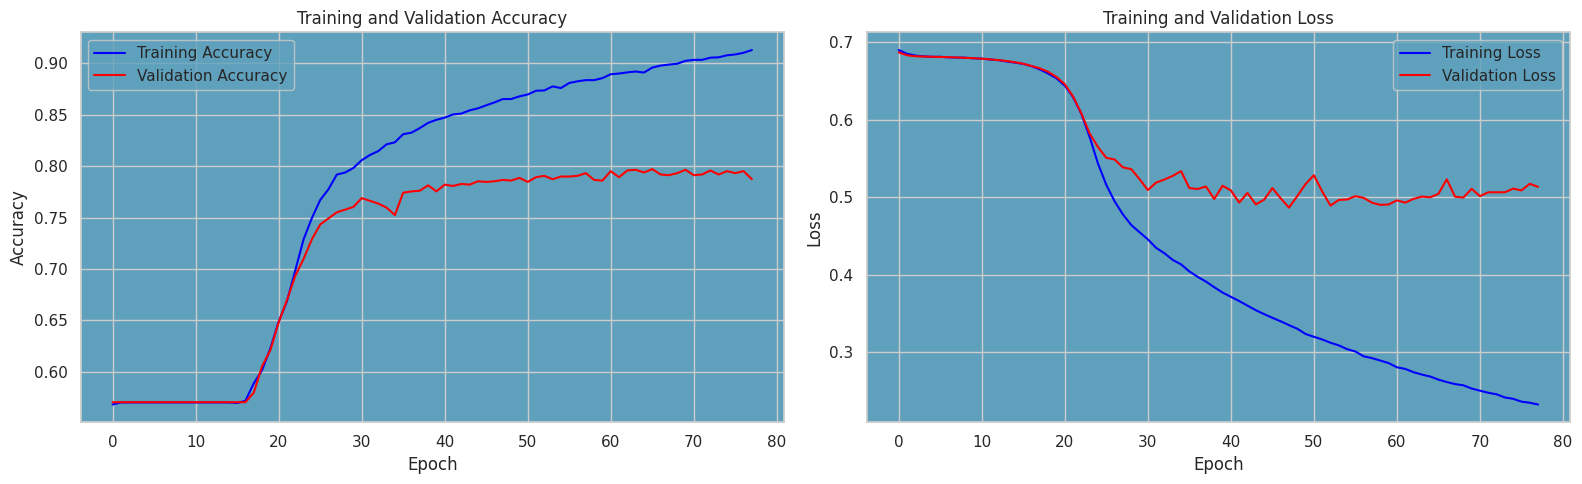

In [47]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
# best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
# axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
# axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [48]:
# Predictions On Test For Confustion Matrix 
y_pred = model.predict(X_test_padded)
y_pred_bin = np.where(y_pred >= 0.5, 1, 0)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [49]:
#submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
test['target'] = y_pred_bin
test[['id', 'target']].to_csv('/kaggle/working/prediction.csv', index=False)